<a href="https://colab.research.google.com/github/schmuecker/machine-learning-course/blob/main/Deep%20Learning/02%20edge_lovers_cnn/02.2%20cl_cnn_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of Faces

In this excercise, we try to classify images of : "Miranda_Cosgrove" "Chris_Martin" "Emma_Stone" "Jamie_Foxx" "Steve_Jobs" "Zac_Efron" "Sandra_Oh" "Taryn_Manning". The data is from a random sample of 8 persons of the OXFORD VGG Face dataset, more information here: http://www.robots.ox.ac.uk/~vgg/data/vgg_face/.

## Downloading of Data

You can download the data using the following code:

In [19]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [20]:
# Downloading the data, if it does not exist, this will take some time... (>120MB)
import urllib
import os
if not os.path.isfile('8_faces_train_and_valid.hdf5'):
    urllib.request.urlretrieve("https://www.dropbox.com/s/dx03vk6dmbtoywn/8_faces_train_and_valid.hdf5?dl=1","8_faces_train_and_valid.hdf5")
!ls -l 8_faces_train_and_valid.hdf5

-rw-r--r--  1 tobias  staff  132733792 Jan 13 10:57 8_faces_train_and_valid.hdf5


In [21]:
import h5py
h5f_X = h5py.File('8_faces_train_and_valid.hdf5', 'r')
print(list(h5f_X.keys()))
X_train = h5f_X['X_train_8_faces']
print(X_train.shape)
Y_train = h5f_X['Y_train_8_faces']
print(Y_train.shape)
X_valid = h5f_X['X_valid_8_faces']
print(X_valid.shape)
Y_valid = h5f_X['Y_valid_8_faces']
print(Y_valid.shape, X_valid.dtype)

['X_train_8_faces', 'X_valid_8_faces', 'Y_train_8_faces', 'Y_valid_8_faces']
(2000, 48, 48, 3)
(2000,)
(400, 48, 48, 3)
(400,) float64


250


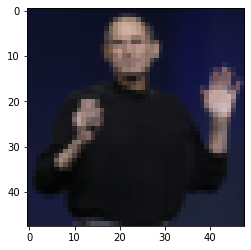

In [22]:
n = 0 #Miranda Cosgrove
n = 1 #Chris Martin (singer)
n = 2 #Emma Stone (actress)
n = 3 #Jamie Foxx (actor)
n = 4 #Steve Jobs (entrepreneur)
n = 5 #Zac Efron (actor)
n = 6 #Sandra Oh (actress)
n = 7 #Taryn Manning (actress)
n = 4 
idx=np.reshape(np.where(Y_train[0:len(Y_train)]==n),(250))
print(len(Y_train[idx]))
plt.imshow(np.asarray(X_train[idx][0],dtype="uint8"))

In [23]:
#Downloading the data, if it does not exist
if not os.path.isfile('8_faces_test.hdf5'):
  urllib.request.urlretrieve("https://www.dropbox.com/s/ugxrdo0lpc2ixvr/8_faces_test.hdf5?dl=1","8_faces_test.hdf5")
h5f_X = h5py.File('8_faces_test.hdf5', 'r')
print(list(h5f_X.keys()))
X_test = h5f_X['X_test_8_faces']
print(X_test.shape)
Y_test = np.reshape(h5f_X['Y_test_8_faces'], (400,1))
print(Y_test.shape)

['X_test_8_faces', 'Y_test_8_faces']
(400, 48, 48, 3)
(400, 1)


In [24]:
np.min(X_train),np.max(X_train),np.min(X_test),np.max(X_test)
X_train = np.true_divide(X_train, 255)
X_valid = np.true_divide(X_valid, 255)
X_test = np.true_divide(X_test, 255)

## a) Training an CNN from scratch

Train a model (as shown below) from scratch, using the training data for training and the validation data for validation. For all activations in the hidden layer use the 'ReLU', for the last layer use softmax. Use 3x3 convolutions and use padding = same.

* Plot the learning curves: (epochs vs training loss and validation loss) and epochs vs accuracy. 
* Calculate the accuracy on the test set (you should reach an accuracy of about 0.54)
* Calculate the confusion matrix
* Have a look at missclassified examples

Image of the network:
https://github.com/ioskn/mldl_htwg/blob/master/uebungen/dl_cnn_faces_net.png

In [25]:
import tensorflow.keras as keras
from tensorflow.keras.optimizers import SGD

model = keras.Sequential()

# Layers
model.add(Conv2D(15, kernel_size=3, padding="same", input_shape=(48, 48, 3)))
model.add(Activation('relu'))
model.add(Conv2D(15, kernel_size=3, padding="same", input_shape=(48, 48, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(30, kernel_size=3, padding="same", input_shape=(48, 48, 3)))
model.add(Activation('relu'))
model.add(Conv2D(30, kernel_size=3, padding="same", input_shape=(48, 48, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Flatten())
model.add(Dense(300, activation="relu"))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation="softmax"))

# Model
model.compile(optimizer=SGD(), loss="categorical_crossentropy", metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 15)        420       
                                                                 
 activation_5 (Activation)   (None, 48, 48, 15)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 15)        2040      
                                                                 
 activation_6 (Activation)   (None, 48, 48, 15)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 15)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 30)        4080      
                                                      

In [26]:
from sklearn.preprocessing import OneHotEncoder

def onehot(input):
  onehot_encoder = OneHotEncoder(sparse=False)
  integer_encoded = np.array(input).reshape(len(input), 1)
  return onehot_encoder.fit_transform(integer_encoded)  

Y_train_oh = onehot(Y_train)
Y_valid_oh = onehot(Y_valid)
Y_test_oh = onehot(Y_test)

Epoch 1/20
63/63 [==============================] - 7s 112ms/step - loss: 2.0820 - accuracy: 0.1330 - val_loss: 2.0752 - val_accuracy: 0.1375
Epoch 2/20
63/63 [==============================] - 7s 110ms/step - loss: 2.0741 - accuracy: 0.1305 - val_loss: 2.0698 - val_accuracy: 0.1575
Epoch 3/20
63/63 [==============================] - 7s 111ms/step - loss: 2.0699 - accuracy: 0.1370 - val_loss: 2.0630 - val_accuracy: 0.1600
Epoch 4/20
63/63 [==============================] - 7s 110ms/step - loss: 2.0608 - accuracy: 0.1505 - val_loss: 2.0533 - val_accuracy: 0.1800
Epoch 5/20
63/63 [==============================] - 7s 107ms/step - loss: 2.0476 - accuracy: 0.1770 - val_loss: 2.0368 - val_accuracy: 0.1825
Epoch 6/20
63/63 [==============================] - 7s 107ms/step - loss: 2.0347 - accuracy: 0.1895 - val_loss: 2.0180 - val_accuracy: 0.2350
Epoch 7/20
63/63 [==============================] - 7s 108ms/step - loss: 2.0095 - accuracy: 0.2190 - val_loss: 1.9872 - val_accuracy: 0.2475
Epoch 

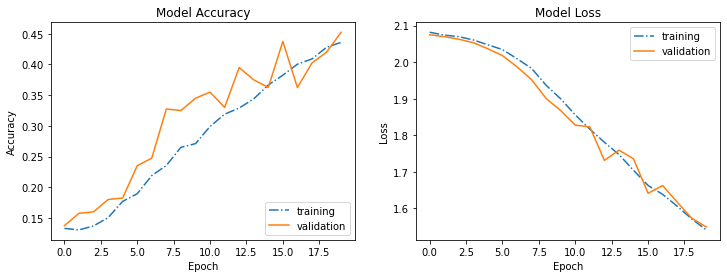

In [27]:
import matplotlib.pyplot as plt

history = model.fit(X_train, Y_train_oh, validation_data=(X_valid, Y_valid_oh), epochs=20)

# Plot
plt.figure(figsize=(12,4))

plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='lower right')

plt.subplot(1,2,(2))
plt.plot(history.history['loss'], linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')

In [28]:
model.evaluate(X_test, Y_test_oh)

13/13 [==============================] - 0s 28ms/step - loss: 1.5352 - accuracy: 0.4575


[1.5352171659469604, 0.45750001072883606]

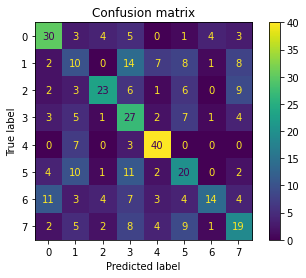

In [29]:
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer

Y_pred = model.predict(X_test)
Y_pred_labels = np.argmax(Y_pred, axis=1)

c = metrics.confusion_matrix(Y_test, Y_pred_labels)
disp = metrics.ConfusionMatrixDisplay(c)
disp.plot()
plt.title('Confusion matrix')
plt.show()

## b) Training using transfer learning
In transfer learning you use an existing trained model with given weights trained on a different task. You then add a few layers yourself and only train them. The model you add should look like:

```
my_dense1 (Dense)            (None, 512)               262656    
_________________________________________________________________
my_dense2 (Dense)            (None, 512)               262656    
_________________________________________________________________
my_dense3 (Dense)            (None, 100)               51300     
_________________________________________________________________
my_dense4 (Dense)            (None, 8)                 808       
```

Use the following code as a starting point:

In [30]:
from tensorflow.keras.applications import VGG16
img_height = img_width = 48
base_model = VGG16(weights='imagenet', include_top=False,input_shape = (img_width, img_height, 3))

In [31]:
fc1 = base_model.output
fc1 = Flatten()(fc1)

fc1 = Dense(512,activation='relu', name='my_dense1')(fc1)
fc1 = Dense(512,activation='relu', name='my_dense2')(fc1)
fc1 = Dense(100,activation='relu', name='my_dense3')(fc1)

fc1 = Dense(8,activation='softmax', name='my_dense4')(fc1)
model_trans = tf.compat.v1.keras.Model(base_model.input, fc1) #Current hack for TF 2.0 and keras

for layer in model_trans.layers:
  name = layer.name
  if name.startswith('my'):
    layer.trainable = True
    print(name)
  else:
    layer.trainable = False

my_dense1
my_dense2
my_dense3
my_dense4


In [32]:
model_trans.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

In [33]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

Do the same analysis as in a) above. You should get an accuracy of approx 0.61

Epoch 1/20
63/63 [==============================] - 20s 308ms/step - loss: 1.9939 - accuracy: 0.2610 - val_loss: 1.9120 - val_accuracy: 0.3550
Epoch 2/20
63/63 [==============================] - 18s 293ms/step - loss: 1.8467 - accuracy: 0.3630 - val_loss: 1.7855 - val_accuracy: 0.3625
Epoch 3/20
63/63 [==============================] - 19s 293ms/step - loss: 1.7289 - accuracy: 0.3975 - val_loss: 1.6917 - val_accuracy: 0.4000
Epoch 4/20
63/63 [==============================] - 20s 310ms/step - loss: 1.6310 - accuracy: 0.4365 - val_loss: 1.6247 - val_accuracy: 0.4200
Epoch 5/20
63/63 [==============================] - 19s 301ms/step - loss: 1.5542 - accuracy: 0.4620 - val_loss: 1.5901 - val_accuracy: 0.4300
Epoch 6/20
63/63 [==============================] - 19s 304ms/step - loss: 1.4903 - accuracy: 0.4825 - val_loss: 1.6355 - val_accuracy: 0.3825
Epoch 7/20
63/63 [==============================] - 20s 315ms/step - loss: 1.4441 - accuracy: 0.4905 - val_loss: 1.5636 - val_accuracy: 0.4025

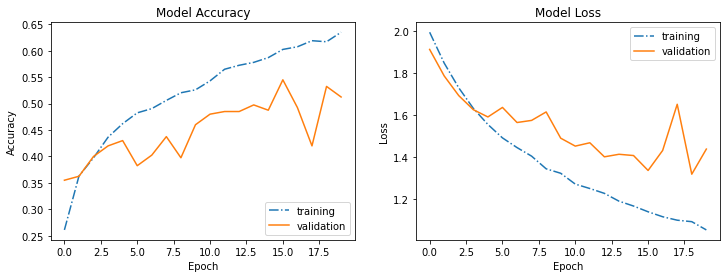

In [34]:
import matplotlib.pyplot as plt

# Compile transformed model
model_trans.compile(optimizer=SGD(), loss="categorical_crossentropy", metrics=['accuracy'])

# Fit transformed model
history = model_trans.fit(X_train, Y_train_oh, validation_data=(X_valid, Y_valid_oh), epochs=20)

# Plot
plt.figure(figsize=(12,4))

plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='lower right')

plt.subplot(1,2,(2))
plt.plot(history.history['loss'], linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')

In [35]:
model_trans.evaluate(X_test, Y_test_oh)

13/13 [==============================] - 3s 251ms/step - loss: 1.2766 - accuracy: 0.5200


[1.2765531539916992, 0.5199999809265137]

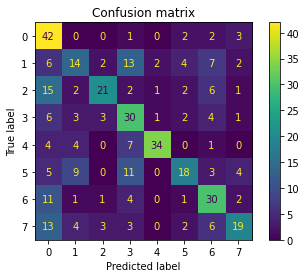

In [36]:
Y_pred = model_trans.predict(X_test)
Y_pred_labels = np.argmax(Y_pred, axis=1)

c = metrics.confusion_matrix(Y_test, Y_pred_labels)
disp = metrics.ConfusionMatrixDisplay(c)
disp.plot()
plt.title('Confusion matrix')
plt.show()

## c) Try to get better.

Ideas: use dropout and other tricks to prevent overfitting. Try to learn some convulutional layers as well.

In [37]:
fc2 = base_model.output
fc2 = Flatten()(fc2)

fc2 = Dense(512, activation='elu', name='my_dense1')(fc2)
fc2 = Dropout(0.2, name='my_dropout1')(fc2)

fc2 = Dense(512, activation='elu', name='my_dense2')(fc2)
fc2 = Dropout(0.2, name='my_dropout2')(fc2)

fc2 = Dense(100, activation='elu', name='my_dense3')(fc2)
fc2 = Dropout(0.2, name='my_dropout3')(fc2)

fc2 = Dense(8, activation='softmax', name='my_dense4')(fc2)
model_trans_2 = tf.compat.v1.keras.Model(base_model.input, fc2) #Current hack for TF 2.0 and keras
model_trans_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

Epoch 1/20
63/63 [==============================] - 19s 296ms/step - loss: 2.1082 - accuracy: 0.1900 - val_loss: 1.8474 - val_accuracy: 0.2775
Epoch 2/20
63/63 [==============================] - 23s 363ms/step - loss: 1.8495 - accuracy: 0.3135 - val_loss: 1.6871 - val_accuracy: 0.3925
Epoch 3/20
63/63 [==============================] - 24s 373ms/step - loss: 1.6937 - accuracy: 0.3745 - val_loss: 1.6169 - val_accuracy: 0.4325
Epoch 4/20
63/63 [==============================] - 19s 300ms/step - loss: 1.6146 - accuracy: 0.4055 - val_loss: 1.5672 - val_accuracy: 0.4375
Epoch 5/20
63/63 [==============================] - 22s 351ms/step - loss: 1.5363 - accuracy: 0.4435 - val_loss: 1.4842 - val_accuracy: 0.4900
Epoch 6/20
63/63 [==============================] - 21s 337ms/step - loss: 1.4746 - accuracy: 0.4610 - val_loss: 1.4703 - val_accuracy: 0.4675
Epoch 7/20
63/63 [==============================] - 22s 345ms/step - loss: 1.4198 - accuracy: 0.4825 - val_loss: 1.4642 - val_accuracy: 0.4650

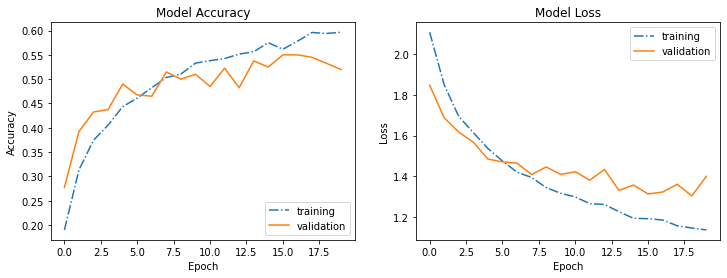

In [38]:
# Compile transformed model
model_trans_2.compile(optimizer=SGD(), loss="categorical_crossentropy", metrics=['accuracy'])

# Fit transformed model
history = model_trans_2.fit(X_train, Y_train_oh, validation_data=(X_valid, Y_valid_oh), epochs=20)

# Plot
plt.figure(figsize=(12,4))

plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='lower right')

plt.subplot(1,2,(2))
plt.plot(history.history['loss'], linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')

In [39]:
model_trans_2.evaluate(X_test, Y_test_oh)

13/13 [==============================] - 3s 244ms/step - loss: 1.2749 - accuracy: 0.5400


[1.274856686592102, 0.5400000214576721]

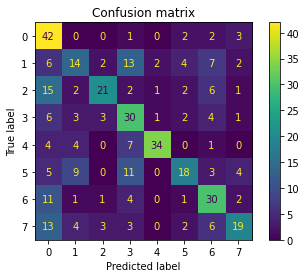

In [40]:
Y_pred_2 = model_trans_2.predict(X_test)
Y_pred_labels_2 = np.argmax(Y_pred, axis=1)

c = metrics.confusion_matrix(Y_test, Y_pred_labels_2)
disp = metrics.ConfusionMatrixDisplay(c)
disp.plot()
plt.title('Confusion matrix')
plt.show()